### Continuity


> Samples are needed for sequence models and transformer models for input

😈 **Task 1:** Why might LSTM be more effective for time series than a feedforward model like MLP?

😈 **Question 1:** What types of patterns are LSTM models particularly good at capturing?



In [ ]:
!pip install statsmodels tensorflow

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import os

context_window = 336
prediction_horizon = 96
# variable_column = ["no2", "temp", "o3", "no", "press"]
variable_column = ["temp"]

In [19]:
# Function to evaluate model performance
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse:.4f}")
    return rmse

In [ ]:
import pickle
## Processed data .pkl files are also made available for the select stations in URL:
# only temp : https://drive.google.com/drive/folders/197WGFswCLYinkx-48XBMQKILwJQMokd0?usp=drive_link

with open("./content/X_test.pkl", "rb") as f:
    X_test = pickle.load(f)

with open("./content/y_train.pkl", "rb") as f:
    y_train = pickle.load(f)

with open("./content/y_test.pkl", "rb") as f:
    y_test = pickle.load(f)

with open("./content/X_train.pkl", "rb") as f:
    X_train = pickle.load(f)

# Flatten input features
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], len(variable_column))  # (samples, 24*5)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], len(variable_column))
X_test = X_test.reshape(X_test.shape[0], X_train.shape[1],  len(variable_column))
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1],  len(variable_column))

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (319325, 336, 1), y_train shape: (319325, 96, 1)
X_test shape: (79832, 336, 1), y_test shape: (79832, 96, 1)


In [ ]:

## Normalized data csv is also made available for the select stations in URL:
# all 5 varibles: https://drive.google.com/file/d/1cmTTWY3f18SikgRBcZzhtFswIf7XwPJq/view?usp=drive_link
dataframe = pd.read_csv(r"./content/timeseries_data/raw_data.csv")
scaler_stats = {col: {'mean': dataframe[col].mean(), 'std': dataframe[col].std()} for col in variable_column}


### Forecasting with Recurrent NN : LSTM

> LSTM multi step ahead and one step ahead predictions

😈 **Task 2:** Compare LSTM results with previous MLP results. What differences do you observe in performance and loss curves?

😈 **Task 3:** Visualize hidden states or prediction errors over time.

In [22]:
# Tunable LSTM parameters
lstm_units = 50
lstm_epochs = 5
lstm_batch_size = 16
lstm_optim = 'adam'
lstm_loss = 'mse'
num_variables = len(variable_column)
# Reshape as a sanity check
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], len(variable_column)))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], len(variable_column)))

#### Multi Step ahead prediction

> Loss accumulation is expected when you do a multi step ahead prediction via LSTM or any sequential model. Due to error propagation, uncertainty growth, data distribution shift. However techniques like scheduled sampling, teacher forcing, and attention mechanisms (as we will illustrate below in transformer architecture) can be used for improvements


😈 **Question 2:** Why does error accumulate in multi-step forecasting?

😈 **Task 4:** Implement scheduled sampling or try a basic attention layer in your LSTM.

In [ ]:
## checkpoint .zip can be loaded and unarchived from this url
# https://drive.google.com/drive/folders/1svSuEHTDMrkL_CrHqYHgtp2ZuWOuFTXS?usp=drive_link
checkpoint_dir = "./checkpoint/lstm_multi_step_checkpoint_96"
os.makedirs(checkpoint_dir, exist_ok=True)

training_histories = {}
lstm_models = {}

for var_idx, col in enumerate(variable_column):
    print(f"\nTraining LSTM for variable {var_idx + 1}/{len(variable_column)}: {col}")

    X_train_single = X_train_lstm[:, :, var_idx]
    y_train_single = y_train[:, :, var_idx].reshape(y_train.shape[0], -1)

    checkpoint_path = os.path.join(checkpoint_dir, f"lstm_var{var_idx}.h5")
    ## Ignore user warning on keras as the choice for this exercise is to use h5.

    if os.path.exists(checkpoint_path):
        print(f"Loading existing model for variable {col}")
        lstm_model = load_model(checkpoint_path,custom_objects={"mse": MeanSquaredError()})
    else:
        print(f"Training new model for variable {col}")

        lstm_model = Sequential([
            LSTM(lstm_units, return_sequences=True, input_shape=(context_window, 1)),
            LSTM(lstm_units, return_sequences=False),
            Dense(prediction_horizon)
        ])

        lstm_model.compile(optimizer="adam", loss="mse")

        checkpoint_callback = ModelCheckpoint(
            checkpoint_path, monitor="val_loss", save_best_only=True, verbose=1
        )

        training = lstm_model.fit(
            X_train_single.reshape(-1, context_window, 1),
            y_train_single,
            epochs=lstm_epochs, batch_size=lstm_batch_size,
            validation_split=0.2, verbose=1,
            callbacks=[checkpoint_callback]
        )

        training_histories[col] = training.history

    lstm_models[col] = lstm_model

lstm_predictions = np.zeros_like(y_test)
y_test_actual = np.zeros_like(y_test)

# scaler_stats = {col: {'mean': dataframes[col].mean(), 'std': dataframes[col].std()} for col in variable_column}
data_raw = pd.read_csv(r"./content/timeseries_data/raw_data.csv",
    parse_dates=["datetime"],
)
scaler_stats = {col: {'mean': data_raw[col].mean(), 'std': data_raw[col].std()} for col in variable_column}

# Evaluate and denormalizing
for var_idx, col in enumerate(variable_column):
    print(f"Predicting for {col}...")

    X_test_single = X_test_lstm[:, :, var_idx]
    lstm_model = lstm_models[col]

    lstm_pred_single = lstm_model.predict(X_test_single.reshape(-1, context_window, 1))
    lstm_predictions[:, :, var_idx] = lstm_pred_single

    lstm_predictions[:, :, var_idx] = (
        lstm_predictions[:, :, var_idx] * scaler_stats[col]['std'] + scaler_stats[col]['mean']
    )
    y_test_actual[:, :, var_idx] = (
        y_test[:, :, var_idx] * scaler_stats[col]['std'] + scaler_stats[col]['mean']
    )


Training LSTM for variable 1/1: temp
Loading existing model for variable temp
Predicting for temp...
2495/2495 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step


In [26]:
for var_idx in range(num_variables):
    y_test_single = y_test_actual[:, :, var_idx]
    y_pred_single = lstm_predictions[:, :, var_idx]

    print(f"Variable {variable_column[var_idx]}:")

    # Evaluate the model for this variable
    evaluate_model(y_test_single, y_pred_single)

Variable temp:
RMSE: 3.4425


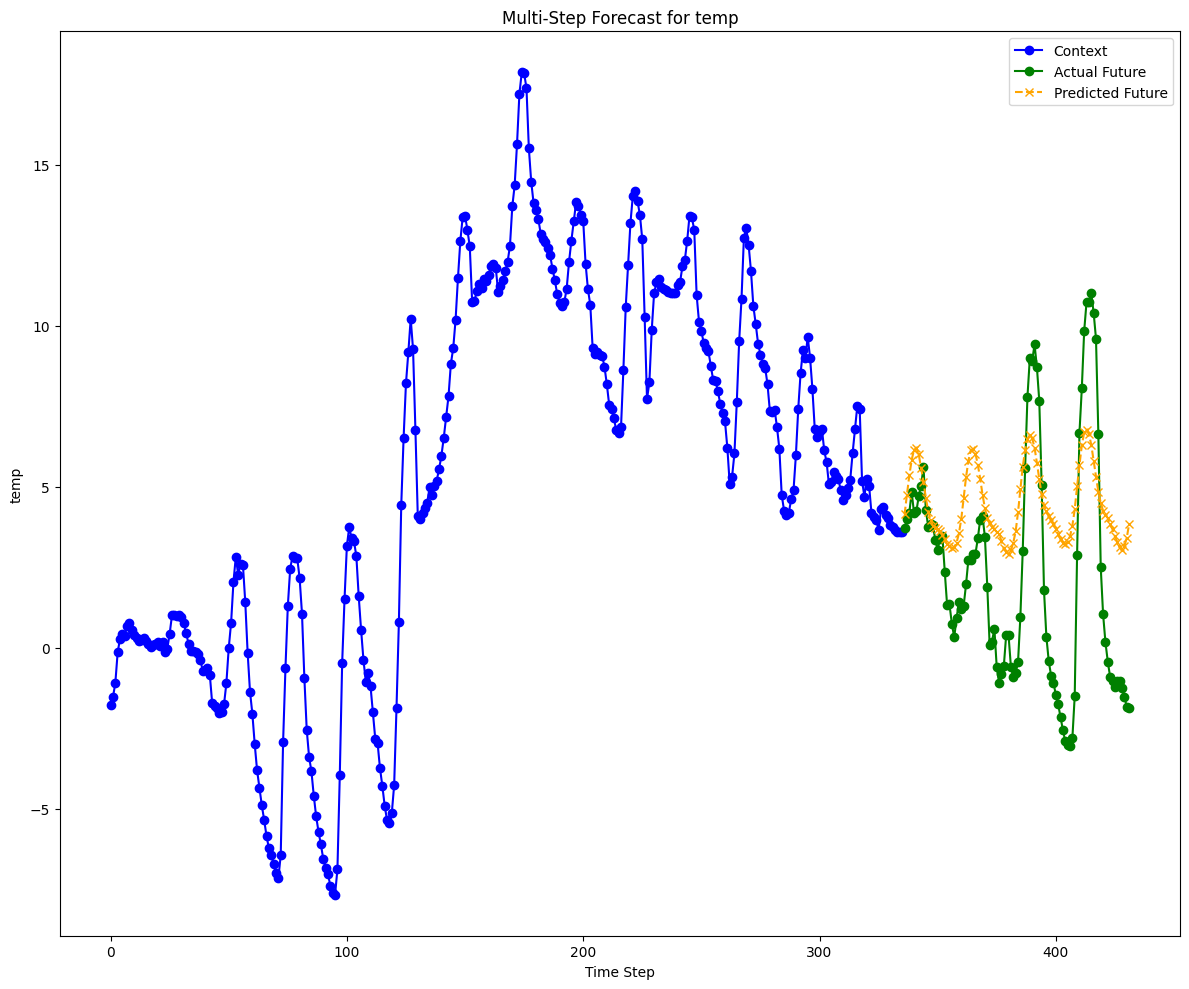

In [27]:
plt.figure(figsize=(12, 10))

for var_idx, col in enumerate(variable_column):
    plt.subplot(len(variable_column), 1, var_idx + 1)

    # Extract data for the last sample
    context = X_test[-1, :, var_idx] * scaler_stats[col]['std'] + scaler_stats[col]['mean']
    actual_future = y_test_actual[-1, :, var_idx] #actual and pred denormalized in prev cell
    predicted_future = lstm_predictions[-1, :, var_idx] #actual and pred denormalized in prev cell

    # Plot context
    plt.plot(range(context_window), context, label="Context", color="blue", marker="o")

    # Plot actual future
    plt.plot(
        range(context_window, context_window + prediction_horizon),
        actual_future,
        label="Actual Future",
        color="green",
        marker="o"
    )

    # Plot predicted future
    plt.plot(
        range(context_window, context_window + prediction_horizon),
        predicted_future,
        label="Predicted Future",
        color="orange",
        linestyle="--",
        marker="x"
    )

    plt.title(f"Multi-Step Forecast for {col}")
    plt.xlabel("Time Step")
    plt.ylabel(col)
    plt.legend()

plt.tight_layout()
plt.show()


#### One Step ahead prediction

😈 **Task 5:** Train both one-step and multi-step models on the same dataset and compare RMSE.

😈 **Question 3:** In what real-world scenario would one-step prediction be more useful than multi-step?


In [ ]:
## checkpoint .zip can be loaded and unarchived from this url
# https://drive.google.com/drive/folders/11xQT7xvmA5Pj9VKck3C4wTOEUvX2gnIJ?usp=drive_link
checkpoint_dir = "./checkpoint/lstm_one_step_checkpoints_96"
os.makedirs(checkpoint_dir, exist_ok=True)

training_histories = {}
lstm_models = {}

for var_idx, col in enumerate(variable_column):
    print(f"\nTraining LSTM for variable {var_idx + 1}/{len(variable_column)}: {col}")

    X_train_single = X_train_lstm[:, :, var_idx]
    y_train_single = y_train[:, 0, var_idx]

    checkpoint_path = os.path.join(checkpoint_dir, f"lstm_one_step_var{var_idx}.h5")
    ## Ignore user warning on keras as the choice for this exercise is to use h5.

    if os.path.exists(checkpoint_path):
        print(f"Loading existing model for variable {col}")
        lstm_model = load_model(checkpoint_path,custom_objects={"mse": MeanSquaredError()})
    else:
        print(f"Training new model for variable {col}")

        lstm_model = Sequential([
            LSTM(lstm_units, return_sequences=True, input_shape=(context_window, 1)),
            LSTM(lstm_units, return_sequences=False),
            Dense(1)
        ])

        lstm_model.compile(optimizer=lstm_optim, loss=lstm_loss)

        checkpoint_callback = ModelCheckpoint(
            checkpoint_path, monitor="val_loss", save_best_only=True, verbose=1
        )

        training = lstm_model.fit(
            X_train_single.reshape(-1, context_window, 1),
            y_train_single.reshape(-1, 1),
            epochs=lstm_epochs, batch_size=lstm_batch_size,
            validation_split=0.2, verbose=1,
            callbacks=[checkpoint_callback]
        )

        training_histories[col] = training.history

    lstm_models[col] = lstm_model
lstm_predictions = np.zeros((y_test.shape[0], len(variable_column)))
y_test_actual = np.zeros((y_test.shape[0], len(variable_column)))

# scaler_stats = {col: {'mean': dataframes[col].mean(), 'std': dataframes[col].std()} for col in variable_column}
data_raw = pd.read_csv(r"./content/timeseries_data/raw_data.csv",
    parse_dates=["datetime"],
)
scaler_stats = {col: {'mean': data_raw[col].mean(), 'std': data_raw[col].std()} for col in variable_column}

# Predict
for var_idx, col in enumerate(variable_column):
    print(f"Predicting for {col}...")

    X_test_single = X_test_lstm[:, :, var_idx]
    lstm_model = lstm_models[col]

    lstm_pred_single = lstm_model.predict(X_test_single.reshape(-1, context_window, 1)).flatten()
    lstm_predictions[:, var_idx] = lstm_pred_single

    # Inverse transform predictions and actual values
    lstm_predictions[:, var_idx] = (
        lstm_predictions[:, var_idx] * scaler_stats[col]['std'] + scaler_stats[col]['mean']
    )
    y_test_actual[:, var_idx] = (
        y_test[:, 0, var_idx] * scaler_stats[col]['std'] + scaler_stats[col]['mean']
    )



Training LSTM for variable 1/1: temp
Loading existing model for variable temp
Predicting for temp...
2495/2495 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step


In [32]:
for var_idx in range(num_variables):
    y_test_single = y_test_actual[ :, var_idx]
    y_pred_single = lstm_predictions[ :, var_idx]

    print(f"Variable {variable_column[var_idx]}:")

    # Evaluate the model for this variable
    evaluate_model(y_test_single, y_pred_single)

Variable temp:
RMSE: 0.6282


In [33]:
lstm_rolling_predictions = np.zeros((prediction_horizon, len(variable_column)))
y_test_actual = np.zeros((prediction_horizon, len(variable_column)))

# Select the last sample from the test set
X_test_single = X_test_lstm[-1]

for var_idx, col in enumerate(variable_column):
    X_test_var = X_test_single[:, var_idx].reshape(1, context_window, 1)

    for step in range(prediction_horizon):
        lstm_pred_single = lstm_models[col].predict(X_test_var)

        lstm_rolling_predictions[step, var_idx] = lstm_pred_single[0, 0]

        # Shift the window and append the new prediction
        X_test_var = np.roll(X_test_var, shift=-1, axis=1)
        X_test_var[0, -1, 0] = lstm_pred_single

    # Inverse scale the predictions and actual values for the current variable
    lstm_rolling_predictions[:, var_idx] = (
        lstm_rolling_predictions[:, var_idx] * scaler_stats[col]['std'] + scaler_stats[col]['mean']
    )
    y_test_actual[:, var_idx] = (
        y_test[-1, :prediction_horizon, var_idx] * scaler_stats[col]['std'] + scaler_stats[col]['mean']
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


<ipython-input-33-7b792f268765>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test_var[0, -1, 0] = lstm_pred_single


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

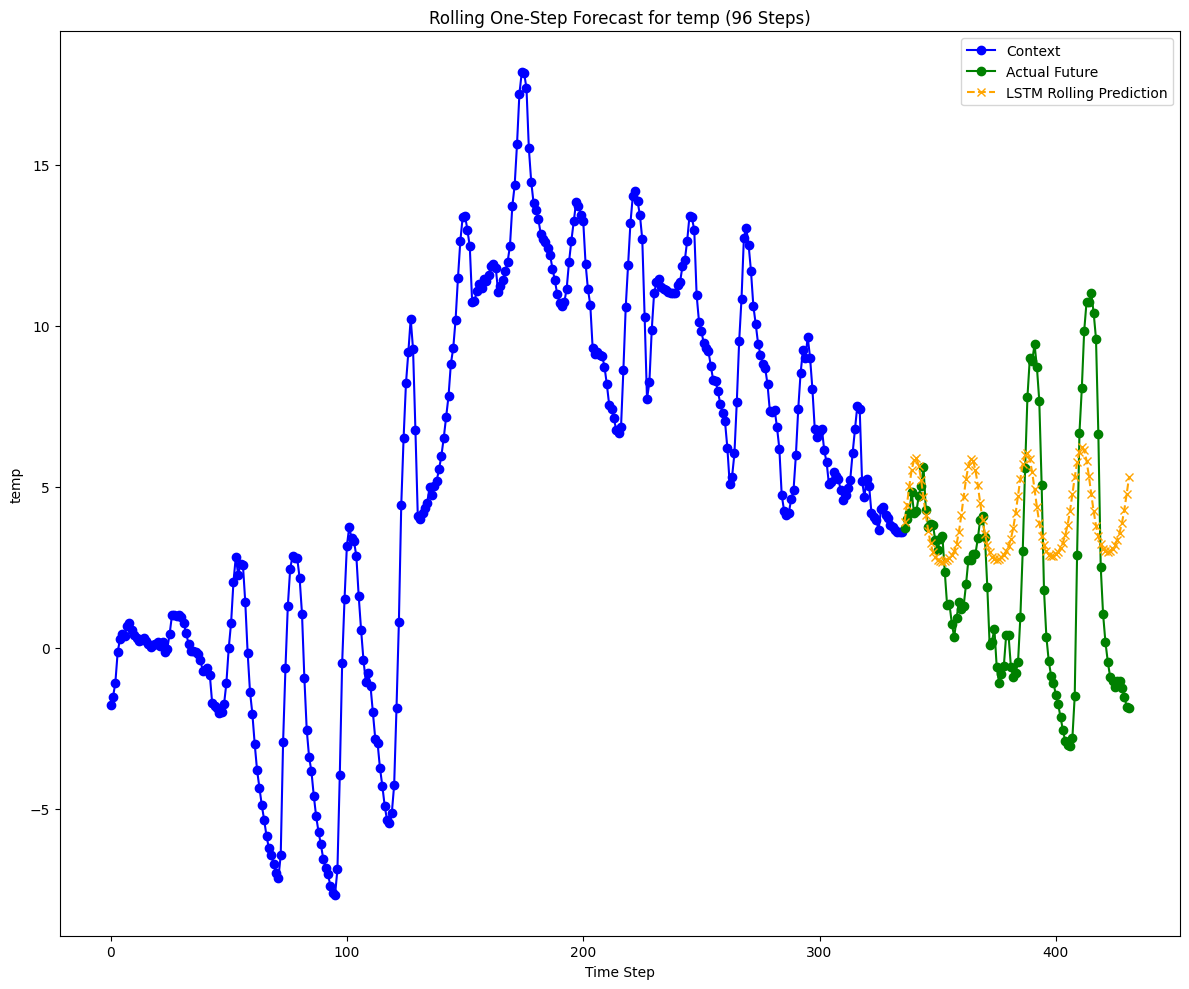

In [34]:
# Plot Rolling One-Step-Ahead Forecast for All Variables (for the last sample)
plt.figure(figsize=(12, 10))

for var_idx, col in enumerate(variable_column):
    plt.subplot(len(variable_column), 1, var_idx + 1)

    context = X_test_lstm[-1, :, var_idx] * scaler_stats[col]['std'] + scaler_stats[col]['mean']
    actual_future = y_test_actual[:, var_idx] #actual and pred denormalized in prev cell
    predicted_future = lstm_rolling_predictions[:, var_idx] #actual and pred denormalized in prev cell

    # Plot context window
    plt.plot(range(context_window), context, label="Context", color="blue", marker="o")

    plt.plot(range(context_window, context_window + prediction_horizon), actual_future,
             label="Actual Future", color="green", marker="o")

    plt.plot(range(context_window, context_window + prediction_horizon), predicted_future,
             label="LSTM Rolling Prediction", color="orange", linestyle="--", marker="x")

    plt.title(f"Rolling One-Step Forecast for {col} ({prediction_horizon} Steps)")
    plt.xlabel("Time Step")
    plt.ylabel(col)
    plt.legend()

plt.tight_layout()
plt.show()